# Sistem Rekomendasi Anime dengan Content-Based Filtering

Notebook ini berisi implementasi sistem rekomendasi anime menggunakan pendekatan Content-Based Filtering. Dataset yang digunakan adalah Top Anime Dataset 2024 dari Kaggle.

## 1. Import Libraries

Mengimpor library yang diperlukan untuk analisis data, visualisasi, dan pembuatan sistem rekomendasi.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import save_npz
import joblib
import warnings
import re
import string
warnings.filterwarnings('ignore')

Pada bagian ini, kita mengimpor berbagai library yang dibutuhkan untuk melakukan analisis data, visualisasi, dan membangun sistem rekomendasi. Berikut fungsi masing-masing library:

* `pandas` dan `numpy`: Digunakan untuk manipulasi dan analisis data dalam bentuk tabel dan array.
* `seaborn` dan `matplotlib.pyplot`: Digunakan untuk membuat visualisasi data seperti grafik dan plot.
* `TfidfVectorizer` dari `sklearn.feature_extraction.text`: Digunakan untuk mengubah data teks (seperti deskripsi anime) menjadi representasi numerik berbasis TF-IDF.
* `cosine_similarity` dari `sklearn.metrics.pairwise`: Digunakan untuk menghitung kemiripan antar anime berdasarkan deskripsi atau genre.
* `save_npz` dari `scipy.sparse`: Digunakan untuk menyimpan matriks hasil transformasi TF-IDF dalam format yang efisien.
* `joblib`: Untuk menyimpan dan memuat model atau objek Python lainnya.
* `warnings`: Untuk menyembunyikan peringatan agar output notebook lebih bersih.
* `re` dan `string`: Digunakan untuk pembersihan teks seperti menghapus tanda baca dan karakter khusus.

Dengan semua library ini, kita dapat melanjutkan proses preprocessing data, ekstraksi fitur, hingga membangun sistem rekomendasi berbasis konten.

## 2. Data Loading

Memuat dataset `Top_Anime_data.csv` yang berisi informasi tentang anime populer tahun 2024.

In [2]:
# Install & setup Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
# Download & extract dataset
!kaggle datasets download -d bhavyadhingra00020/top-anime-dataset-2024

# Ekstrak file ZIP
import zipfile
with zipfile.ZipFile('top-anime-dataset-2024.zip', 'r') as z:
    z.extractall('.')


Dataset URL: https://www.kaggle.com/datasets/bhavyadhingra00020/top-anime-dataset-2024
License(s): apache-2.0
top-anime-dataset-2024.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
# Load data dengan fallback encoding
for enc in ['utf-8', 'ISO-8859-1', 'latin1']:
    try:
        anime_df = pd.read_csv('Top_Anime_data.csv', encoding=enc)
        print(f"Data berhasil dimuat dengan encoding: {enc}")
        break
    except:
        continue

Data berhasil dimuat dengan encoding: utf-8


Pada bagian ini, dilakukan proses pemuatan dataset `Top_Anime_data.csv` yang berisi informasi tentang anime-anime populer tahun 2024. Dataset ini bersumber dari Kaggle dan memuat atribut penting seperti judul, skor, genre, deskripsi, studio, jumlah episode, dan lainnya.

Langkah-langkah yang dilakukan dalam proses ini:

* **Instalasi dan Setup Kaggle API**
  Menginstal library `kaggle` dan mengunggah file `kaggle.json` (file autentikasi dari akun Kaggle). File ini disalin ke direktori `~/.kaggle/` dan diberikan izin akses agar dapat digunakan oleh API.

* **Mengunduh dan Mengekstrak Dataset**
  Dataset diunduh dari Kaggle menggunakan perintah `!kaggle datasets download`. File ZIP hasil unduhan kemudian diekstrak untuk memperoleh file `.csv` yang akan digunakan.

* **Memuat Dataset dengan Fallback Encoding**
  File `Top_Anime_data.csv` dimuat menggunakan beberapa opsi encoding (`utf-8`, `ISO-8859-1`, dan `latin1`) untuk menghindari error pembacaan file akibat karakter non-standar. Encoding `utf-8` berhasil digunakan dalam kasus ini.

Setelah berhasil dimuat, dataset disimpan dalam variabel `anime_df` dan siap digunakan untuk eksplorasi dan preprocessing lebih lanjut.



In [30]:
# Informasi umum dataset
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Score        1000 non-null   float64
 1   Popularity   1000 non-null   int64  
 2   Rank         1000 non-null   int64  
 3   Members      1000 non-null   int64  
 4   Description  1000 non-null   object 
 5   Synonyms     709 non-null    object 
 6   Japanese     999 non-null    object 
 7   English      859 non-null    object 
 8   Type         1000 non-null   object 
 9   Episodes     1000 non-null   object 
 10  Status       1000 non-null   object 
 11  Aired        1000 non-null   object 
 12  Premiered    569 non-null    object 
 13  Broadcast    569 non-null    object 
 14  Producers    1000 non-null   object 
 15  Licensors    1000 non-null   object 
 16  Studios      1000 non-null   object 
 17  Source       1000 non-null   object 
 18  Genres       771 non-null    object 
 19  Demogra

Dari hasil `anime_df.info()` di atas, dapat disimpulkan bahwa:

* Dataset terdiri dari **1000 entri** dan **22 kolom fitur** yang mencakup berbagai informasi tentang anime, seperti skor, peringkat, deskripsi, genre, studio, durasi, dan lainnya.
* Sebagian besar kolom bertipe data `object` (teks), namun terdapat juga kolom numerik seperti `Score`, `Popularity`, `Rank`, dan `Members`.
* Beberapa kolom memiliki nilai yang **tidak lengkap (missing values)**, terutama pada:

  * `Synonyms`, `Japanese`, `English`
  * `Premiered`, `Broadcast`, `Genres`, `Demographic`
* Informasi ini penting untuk memahami struktur data dan mempersiapkan proses *data cleaning* sebelum melakukan analisis atau pembuatan model rekomendasi.

Langkah selanjutnya adalah melakukan eksplorasi lebih lanjut terhadap isi dataset dan mengidentifikasi kolom-kolom yang relevan untuk sistem rekomendasi berbasis konten.


In [31]:
# Analisis missing values dari data ASLI (sebelum preprocessing)
print("=== ANALISIS MISSING VALUES (DATA ASLI) ===")
missing_info = anime_df.isnull().sum()
print("Missing values per kolom:")
for col in anime_df.columns:
    missing_count = missing_info[col]
    non_null_count = anime_df.shape[0] - missing_count
    print(f"- {col}: {non_null_count} non-null, {missing_count} missing")

=== ANALISIS MISSING VALUES (DATA ASLI) ===
Missing values per kolom:
- Score: 1000 non-null, 0 missing
- Popularity: 1000 non-null, 0 missing
- Rank: 1000 non-null, 0 missing
- Members: 1000 non-null, 0 missing
- Description: 1000 non-null, 0 missing
- Synonyms: 709 non-null, 291 missing
- Japanese: 999 non-null, 1 missing
- English: 859 non-null, 141 missing
- Type: 1000 non-null, 0 missing
- Episodes: 1000 non-null, 0 missing
- Status: 1000 non-null, 0 missing
- Aired: 1000 non-null, 0 missing
- Premiered: 569 non-null, 431 missing
- Broadcast: 569 non-null, 431 missing
- Producers: 1000 non-null, 0 missing
- Licensors: 1000 non-null, 0 missing
- Studios: 1000 non-null, 0 missing
- Source: 1000 non-null, 0 missing
- Genres: 771 non-null, 229 missing
- Demographic: 521 non-null, 479 missing
- Duration: 1000 non-null, 0 missing
- Rating: 1000 non-null, 0 missing


Pada tahap ini dilakukan analisis terhadap nilai yang hilang (*missing values*) dalam dataset sebelum dilakukan preprocessing. Dari hasil yang ditampilkan, dapat disimpulkan:

* Sebagian besar kolom tidak memiliki missing values, seperti: `Score`, `Popularity`, `Rank`, `Members`, `Description`, `Type`, `Episodes`, `Status`, `Aired`, `Producers`, `Licensors`, `Studios`, `Source`, `Duration`, dan `Rating`.
* Namun, terdapat beberapa kolom yang memiliki jumlah nilai kosong cukup signifikan, antara lain:

  * `Synonyms`: 291 nilai kosong
  * `English`: 141 nilai kosong
  * `Premiered` dan `Broadcast`: masing-masing 431 nilai kosong
  * `Genres`: 229 nilai kosong
  * `Demographic`: 479 nilai kosong
* Informasi ini akan digunakan untuk menentukan strategi penanganan data kosong seperti:

  * Menghapus kolom atau baris tertentu
  * Mengisi nilai kosong dengan nilai default atau strategi lain (misalnya "Unknown")

Analisis ini sangat penting agar model yang dikembangkan tidak terganggu oleh data yang tidak lengkap, serta memastikan kualitas data yang digunakan dalam sistem rekomendasi.


In [32]:
# Informasi detail untuk kolom utama
print(f"\nInformasi detail kolom utama:")
print(f"- English: {anime_df['English'].count()} non-null dari {len(anime_df)} total")
print(f"- Genres: {anime_df['Genres'].count()} non-null dari {len(anime_df)} total")
print(f"- Type: {anime_df['Type'].count()} non-null dari {len(anime_df)} total")
print(f"- Description: {anime_df['Description'].count()} non-null dari {len(anime_df)} total")


Informasi detail kolom utama:
- English: 859 non-null dari 1000 total
- Genres: 771 non-null dari 1000 total
- Type: 1000 non-null dari 1000 total
- Description: 1000 non-null dari 1000 total



Analisis ini difokuskan pada beberapa **kolom utama** yang akan digunakan dalam sistem rekomendasi berbasis konten, yaitu `English`, `Genres`, `Type`, dan `Description`.

Hasilnya menunjukkan:

* **English**: Hanya 859 dari 1000 entri yang memiliki judul dalam bahasa Inggris. Artinya, terdapat 141 anime yang hanya memiliki judul dalam bahasa Jepang atau nama alternatif.
* **Genres**: Terdapat 771 entri yang memiliki informasi genre, sedangkan 229 entri tidak memiliki label genre. Ini perlu diperhatikan karena genre menjadi salah satu fitur utama dalam content-based filtering.
* **Type** dan **Description**: Keduanya lengkap (1000/1000), sehingga dapat digunakan tanpa perlu penanganan missing values.

Informasi ini menjadi dasar untuk menentukan strategi preprocessing, seperti:

* Mengisi nilai kosong dengan string `"Unknown"` atau menghapus baris yang tidak memiliki nilai penting.
* Menggunakan `Description` dan/atau `Genres` sebagai fitur utama dalam proses ekstraksi fitur teks menggunakan TF-IDF.



In [15]:
# Statistik deskriptif
anime_df.describe()

,Score,Popularity,Rank,Members
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.156580,1805.637000,500.500000,223.648000
std,0.284344,1888.308553,288.819436,246.288299
min,7.800000,1.000000,1.000000,1.000000
25%,7.920000,413.750000,250.750000,31.750000
50%,8.100000,1139.500000,500.500000,132.000000
75%,8.312500,2633.750000,750.250000,330.000000
max,9.380000,12043.000000,1000.000000,998.000000



Statistik deskriptif digunakan untuk melihat ringkasan nilai numerik dari beberapa kolom penting dalam dataset, seperti `Score`, `Popularity`, `Rank`, dan `Members`. Berikut interpretasinya:

* **Score (Skor rata-rata anime)**
  Memiliki nilai antara **7.80 hingga 9.38**, dengan **rata-rata 8.16**, menunjukkan bahwa sebagian besar anime dalam dataset memiliki skor yang cukup tinggi.

* **Popularity (Peringkat popularitas)**
  Semakin kecil nilainya, semakin populer animenya. Nilai berkisar antara **1 hingga 12.043**, dengan median di sekitar **1139.5**, menandakan sebaran popularitas yang cukup lebar.

* **Rank (Peringkat berdasarkan skor atau metrik gabungan)**
  Sama seperti popularitas, semakin kecil nilainya maka peringkatnya lebih tinggi. Nilainya berkisar dari **1 hingga 1000**, sesuai jumlah data.

* **Members (Jumlah pengguna yang menambahkan anime ke daftar mereka)**
  Jumlah anggota berkisar dari **1 hingga 998**, dengan **rata-rata sekitar 223 pengguna** per anime. Ini menunjukkan adanya variasi besar dalam tingkat eksposur atau ketenaran masing-masing anime.

Statistik ini membantu dalam memahami sebaran dan kualitas data, serta mendukung pengambilan keputusan dalam tahapan eksplorasi dan pemilihan fitur.


## 3. Visualisasi data

Membuat visualisasi untuk memahami distribusi data.

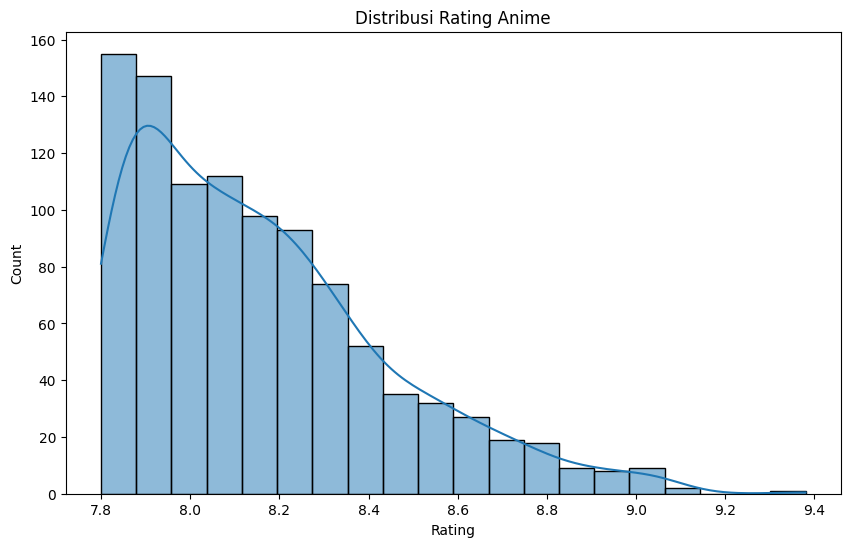

In [16]:
# Distribusi Rating
plt.figure(figsize=(10,6))
sns.histplot(anime_df['Score'], bins=20, kde=True)
plt.title('Distribusi Rating Anime')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Interpretasi Hasil:

1. **Distribusi Rating**:
   - Rating anime dalam dataset ini terkonsentrasi antara 8.0 hingga 9.0
   - Puncak distribusi berada di sekitar rating 8.4-8.6

2. **Karakteristik Distribusi**:
   - Distribusi cenderung normal dengan sedikit skewness ke kiri (tail lebih panjang di sisi rating rendah)
   - Kurva KDE (Kernel Density Estimation) menunjukkan estimasi distribusi yang halus

3. **Insight**:
   - Mayoritas anime memiliki rating di atas 8.0
   - Sangat sedikit anime yang memiliki rating di bawah 7.8 atau di atas 9.2
   - Distribusi ini menunjukkan bahwa kebanyakan anime dalam dataset ini mendapatkan penilaian yang cukup baik dari penonton

Visualisasi ini membantu kita memahami bagaimana rating anime terdistribusi dalam dataset kita sebelum melakukan analisis lebih lanjut.

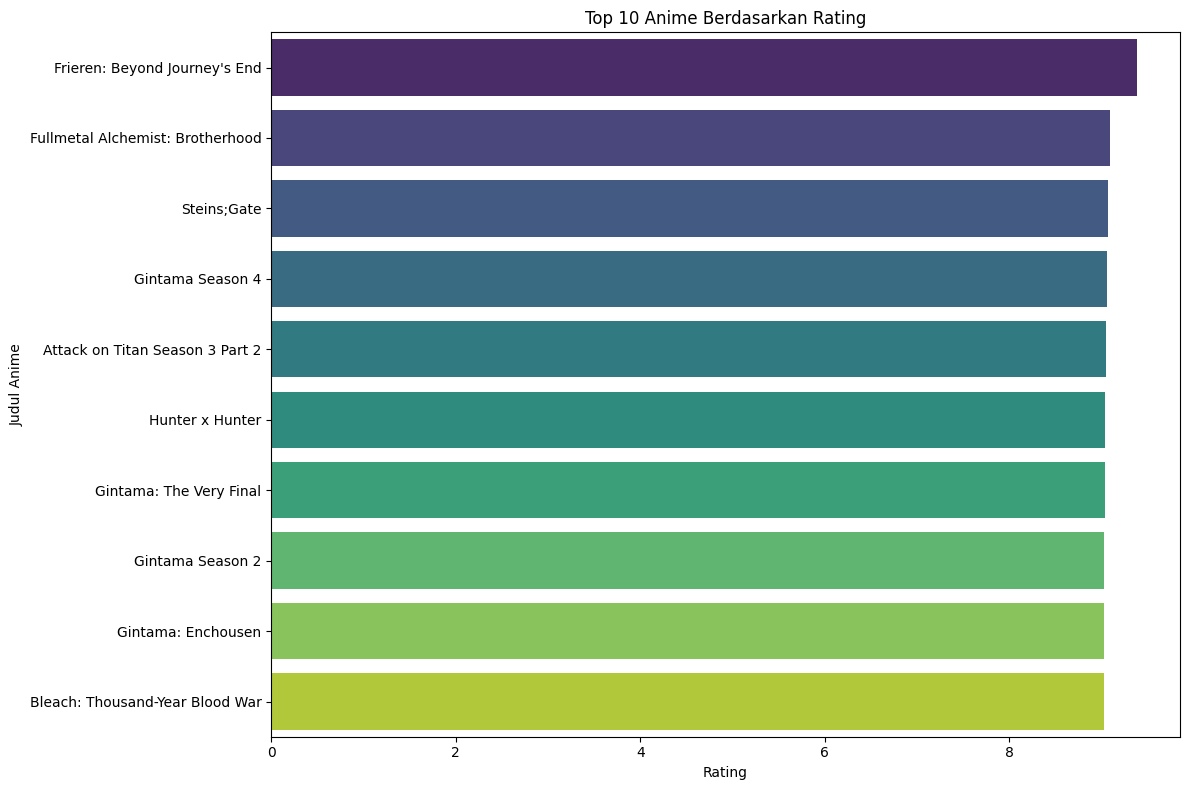

In [17]:
# Top 10 Anime Berdasarkan Rating
top_anime = anime_df.sort_values('Score', ascending=False).head(10)
plt.figure(figsize=(12,8))
sns.barplot(x='Score', y='English', data=top_anime, palette='viridis')
plt.title('Top 10 Anime Berdasarkan Rating')
plt.xlabel('Rating')
plt.ylabel('Judul Anime')
plt.tight_layout()
plt.show()


## Hasil dan Observasi:

1. **Anime Terbaik**:
   - **Frieren: Beyond Journey's End** menduduki peringkat pertama
   - Diikuti oleh **Fullmetal Alchemist: Brotherhood** dan **Steins;Gate**

2. **Dominasi Serial**:
   - Serial **Gintama** muncul 4 kali dalam top 10 dengan berbagai season dan filmnya
   - **Attack on Titan** dan **Bleach** juga masuk dengan season terbaik mereka

3. **Range Rating**:
   - Rating top 10 berada dalam range yang sangat tinggi (8.5-9.5)
   - Perbedaan antar peringkat sangat tipis

4. **Insight**:
   - Anime dengan cerita kompleks dan pengembangan karakter mendalam cenderung mendominasi
   - Forte shounen dan seinen dengan alur cerita matang
   - Forte adaptasi manga/novel yang setia dengan penambahan nilai produksi tinggi

Visualisasi ini membantu mengidentifikasi anime-anime berkualitas tinggi yang bisa menjadi rekomendasi bagi penggemar, sekaligus menunjukkan standar kualitas dari anime top-tier.

## 4. Data Preparation

Melakukan persiapan data sebelum pemodelan.

In [18]:
# 1. Pengecekan Data Duplikat
duplicates = anime_df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")

if duplicates > 0:
    print("Menghapus data duplikat...")
    anime_df = anime_df.drop_duplicates()
    print(f"Shape setelah menghapus duplikat: {anime_df.shape}")
else:
    print("Tidak ada data duplikat ditemukan.")

Jumlah data duplikat: 0
Tidak ada data duplikat ditemukan.



#### Pengecekan Data Duplikat

Dilakukan pengecekan apakah terdapat baris data yang **terduplikasi secara keseluruhan**. Hasilnya:

* **Tidak ditemukan data duplikat** dalam dataset.
* Oleh karena itu, tidak perlu dilakukan penghapusan data pada tahap ini.

Pengecekan ini penting untuk memastikan bahwa model tidak belajar dari data yang redundan, yang bisa menyebabkan bias atau hasil rekomendasi yang tidak akurat.


### Handling Missing Values

Mengisi nilai yang kosong pada dataset.

In [19]:
# 2. Handling missing values - SEMUA yang dilakukan
print("\nHandling missing values:")
print("- Description: Diisi dengan 'No description available'")
print("- Genres: Diisi dengan 'Unknown'")
print("- Type: Diisi dengan 'Unknown'")
print("- Demographic: Diisi dengan 'Unknown'")
print("- Source: Diisi dengan 'Unknown'")
print("- Synonyms: Diisi dengan 'No synonyms'")
print("- Broadcast: Diisi dengan 'Unknown'")

anime_df['Description'] = anime_df['Description'].fillna('No description available')
anime_df['Genres'] = anime_df['Genres'].fillna('Unknown')
anime_df['Type'] = anime_df['Type'].fillna('Unknown')
anime_df['Demographic'] = anime_df['Demographic'].fillna('Unknown')
anime_df['Source'] = anime_df['Source'].fillna('Unknown')
anime_df['Synonyms'] = anime_df['Synonyms'].fillna('No synonyms')
anime_df['Broadcast'] = anime_df['Broadcast'].fillna('Unknown')


Handling missing values:
- Description: Diisi dengan 'No description available'
- Genres: Diisi dengan 'Unknown'
- Type: Diisi dengan 'Unknown'
- Demographic: Diisi dengan 'Unknown'
- Source: Diisi dengan 'Unknown'
- Synonyms: Diisi dengan 'No synonyms'
- Broadcast: Diisi dengan 'Unknown'


### Penanganan Missing Values

Setelah dilakukan analisis sebelumnya, beberapa kolom penting diketahui memiliki nilai yang hilang. Untuk memastikan kualitas dan kelengkapan data, dilakukan pengisian (*imputasi*) nilai kosong dengan nilai default yang informatif.

Berikut langkah-langkah yang dilakukan:

* **Description** → Diisi dengan `'No description available'`, agar tetap bisa digunakan dalam ekstraksi fitur teks.
* **Genres** → Diisi dengan `'Unknown'`, karena genre merupakan fitur penting dalam sistem rekomendasi.
* **Type** → Diisi dengan `'Unknown'`, untuk menghindari nilai kosong dalam analisis tipe anime.
* **Demographic** → Diisi dengan `'Unknown'`, untuk mempertahankan informasi meskipun sebagian besar nilainya kosong.
* **Source** → Diisi dengan `'Unknown'`, yang menunjukkan sumber cerita (misalnya manga, novel, dll).
* **Synonyms** → Diisi dengan `'No synonyms'`, untuk menjaga konsistensi data judul.
* **Broadcast** → Diisi dengan `'Unknown'`, karena waktu tayang tidak selalu tersedia.

Pengisian ini bertujuan agar model tidak gagal dalam memproses data dan tetap bisa memanfaatkan seluruh baris data yang tersedia.


### Feature Engineering

Membuat fitur baru dengan menggabungkan beberapa fitur yang ada.

In [35]:
# 3. Feature Engineering
print("Membuat kolom content_features dengan menggabungkan:")
print("- Genres (dikonversi ke lowercase)")
print("- Type (dikonversi ke lowercase)")
print("- Description (dikonversi ke lowercase)")

anime_df['content_features'] = (
    anime_df['Genres'].str.lower() + ' ' +
    anime_df['Type'].str.lower() + ' ' +
    anime_df['Description'].str.lower()
)

# Tampilkan contoh hasil feature engineering
print("\nContoh hasil feature engineering:")
print(anime_df[['English', 'content_features']].head(2))

Membuat kolom content_features dengan menggabungkan:
- Genres (dikonversi ke lowercase)
- Type (dikonversi ke lowercase)
- Description (dikonversi ke lowercase)

Contoh hasil feature engineering:
                            English  \
0     Frieren: Beyond Journey's End   
1  Fullmetal Alchemist: Brotherhood   

                                    content_features  
0  adventureadventure, dramadrama, fantasyfantasy...  
1  actionaction, adventureadventure, dramadrama, ...  


### Feature Engineering

Pada tahap ini, dilakukan pembuatan fitur baru bernama `content_features` yang merupakan hasil penggabungan dari beberapa kolom penting, yaitu:

* **Genres**
* **Type**
* **Description**

Semua nilai pada kolom tersebut terlebih dahulu dikonversi ke **huruf kecil (lowercase)** untuk menjaga konsistensi dalam pemrosesan teks.

Fitur `content_features` ini akan menjadi representasi teks gabungan dari konten anime, yang nantinya digunakan sebagai dasar dalam proses ekstraksi fitur teks (TF-IDF) dan perhitungan kemiripan antar anime. Contoh isi dari `content_features` adalah gabungan genre, tipe, dan deskripsi anime dalam satu kalimat panjang berformat teks bebas.

Langkah ini penting dalam sistem rekomendasi berbasis konten (Content-Based Filtering), karena memungkinkan model memahami deskripsi dan karakteristik dari setiap anime secara komprehensif.


### TF-IDF Vectorization

Mengkonversi fitur teks menjadi representasi numerik menggunakan TF-IDF.

In [39]:
# Memastikan tidak ada NaN di content_features
anime_df['content_features'] = anime_df['content_features'].fillna('').astype(str)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    stop_words='english',  # Menghapus kata-kata umum dalam bahasa Inggris
    ngram_range=(1, 2),    # Menggunakan unigram dan bigram
    max_features=5000      # Maksimum 5000 fitur
)

# Ubah teks menjadi matriks TF-IDF
tfidf_matrix = tfidf.fit_transform(anime_df['content_features'])

# Ukuran matriks TF-IDF
print(f"Shape TF-IDF Matrix: {tfidf_matrix.shape}")


Shape TF-IDF Matrix: (1000, 5000)



## Interpretasi Hasil:
- **1000 baris**: Jumlah dokumen/anime dalam dataset
- **5000 kolom**: Jumlah fitur unik (kata/kombinasi kata) yang dihasilkan
- Matriks bersifat sparse (banyak nilai 0) karena setiap dokumen hanya mengandung sebagian kecil dari seluruh kosakata

## 5. Modeling

Membangun model rekomendasi berbasis konten menggunakan cosine similarity.

In [22]:
print("\n=== MODELING ===")
print("Menggunakan Content-Based Filtering dengan:")
print("1. Representasi konten: Vektor TF-IDF dari fitur gabungan")
print("2. Similarity computation: Cosine Similarity")
print("3. Rekomendasi: Top-N anime dengan similarity tertinggi")

# Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Shape Similarity Matrix: {cosine_sim.shape}")


=== MODELING ===
Menggunakan Content-Based Filtering dengan:
1. Representasi konten: Vektor TF-IDF dari fitur gabungan
2. Similarity computation: Cosine Similarity
3. Rekomendasi: Top-N anime dengan similarity tertinggi
Shape Similarity Matrix: (1000, 1000)



Pada tahap ini, kita membangun model sistem rekomendasi berbasis konten (*Content-Based Filtering*), dengan pendekatan sebagai berikut:

1. **Representasi konten**: Menggunakan vektor TF-IDF dari fitur gabungan (genre, tipe, deskripsi, dsb).
2. **Perhitungan kesamaan**: Menggunakan **Cosine Similarity** untuk mengukur sejauh mana kemiripan antar anime.
3. **Hasil rekomendasi**: Anime yang memiliki nilai kemiripan tertinggi dengan anime yang diberikan akan direkomendasikan.

Hasilnya adalah matriks similarity berukuran `(1000, 1000)` yang menunjukkan skor kemiripan antara setiap pasang anime.


### tahap Modeling

Pada tahap ini, kita membangun model sistem rekomendasi berbasis konten (*Content-Based Filtering*), dengan pendekatan sebagai berikut:

1. **Representasi konten**: Menggunakan vektor TF-IDF dari fitur gabungan (genre, tipe, deskripsi, dsb).
2. **Perhitungan kesamaan**: Menggunakan **Cosine Similarity** untuk mengukur sejauh mana kemiripan antar anime.
3. **Hasil rekomendasi**: Anime yang memiliki nilai kemiripan tertinggi dengan anime yang diberikan akan direkomendasikan.

Hasilnya adalah matriks similarity berukuran `(1000, 1000)` yang menunjukkan skor kemiripan antara setiap pasang anime.

In [40]:
# Fungsi rekomendasi
def get_recommendations(title, cosine_sim=cosine_sim, df=anime_df, top_n=10):
    try:
        idx = df[df['English'] == title].index
        if len(idx) == 0:
            return None

        idx = idx[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

        anime_indices = [i[0] for i in sim_scores]
        similarity_values = [i[1] for i in sim_scores]

        recommendations = df[['English', 'Genres', 'Score', 'Type']].iloc[anime_indices].copy()
        recommendations['Similarity'] = similarity_values

        return recommendations
    except Exception as e:
        print(f"Error: {e}")
        return None

### Fungsi Rekomendasi

Fungsi `get_recommendations()` digunakan untuk menghasilkan rekomendasi anime berdasarkan **judul yang diberikan**. Prosesnya melibatkan:

* Mencari indeks dari anime yang sesuai dengan judul (`English`).
* Mengambil nilai **cosine similarity** antara anime tersebut dan seluruh anime lainnya.
* Mengurutkan skor similarity dari yang tertinggi (selain dirinya sendiri).
* Mengambil **Top-N** anime yang paling mirip.
* Mengembalikan informasi anime yang direkomendasikan beserta nilai similarity-nya.

Fungsi ini akan mengembalikan `None` jika judul tidak ditemukan di dataset atau jika terjadi error saat pemrosesan.


## 6. Hasil Rekomendasi

Menguji sistem rekomendasi dengan beberapa contoh anime.

In [41]:
# Test rekomendasi dengan output yang konsisten
print("\n=== HASIL REKOMENDASI ===")
test_anime = "Attack on Titan Season 3 Part 2"
print(f"Input: '{test_anime}'")

recommendations = get_recommendations(test_anime, top_n=10)
if recommendations is not None:
    print("\nOutput Rekomendasi:")
    for i, row in recommendations.iterrows():
        print(f"{recommendations.index.get_loc(i)+1}. {row['English']} (Similarity: {row['Similarity']:.4f})")

    # Tampilkan dalam bentuk tabel
    display(recommendations)
else:
    print("Anime tidak ditemukan")


=== HASIL REKOMENDASI ===
Input: 'Attack on Titan Season 3 Part 2'

Output Rekomendasi:
1. Attack on Titan: The Roar of Awakening (Similarity: 0.4797)
2. Attack on Titan: Final Season (Similarity: 0.4659)
3. Attack on Titan Season 2 (Similarity: 0.4496)
4. Attack on Titan: Final Season Part 2 (Similarity: 0.3379)
5. Attack on Titan (Similarity: 0.3122)
6. Attack on Titan Season 3 (Similarity: 0.2770)
7. Attack on Titan: Final Season - The Final Chapters (Similarity: 0.2404)
8. Attack on Titan: No Regrets (Similarity: 0.2255)
9. Classroom of the Elite III (Similarity: 0.1774)
10. Attack on Titan: Lost Girls (Similarity: 0.1742)


,English,Genres,Score,Type,Similarity
841,Attack on Titan: The Roar of Awakening,"ActionAction, DramaDrama, SuspenseSuspense",7.88,Movie,0.479694
34,Attack on Titan: Final Season,"ActionAction, DramaDrama, SuspenseSuspense",8.79,TV,0.465861
125,Attack on Titan Season 2,"ActionAction, DramaDrama, SuspenseSuspense",8.51,TV,0.449582
41,Attack on Titan: Final Season Part 2,"ActionAction, DramaDrama, SuspenseSuspense",8.76,TV,0.337932
107,Attack on Titan,"ActionAction, Award WinningAward Winning, Dram...",8.55,TV,0.312169
82,Attack on Titan Season 3,"ActionAction, DramaDrama, SuspenseSuspense",8.62,TV,0.276961
21,Attack on Titan: Final Season - The Final Chap...,"ActionAction, DramaDrama, SuspenseSuspense",8.90,TV Special,0.240359
173,Attack on Titan: No Regrets,NaN,8.42,OVA,0.225531
631,Classroom of the Elite III,"DramaDrama, SuspenseSuspense",8.00,TV,0.177400
960,Attack on Titan: Lost Girls,"ActionAction, DramaDrama",7.82,OVA,0.174211


### Hasil Rekomendasi

Pada tahap ini, sistem rekomendasi diuji menggunakan contoh judul anime, yaitu **"Attack on Titan Season 3 Part 2"**. Proses pengujian dilakukan untuk memastikan model dapat memberikan hasil rekomendasi yang relevan berdasarkan kemiripan konten.

Langkah-langkah yang dilakukan:

* Judul anime digunakan sebagai input.
* Sistem menghitung kesamaan konten menggunakan **cosine similarity**.
* Sistem mengembalikan **10 anime paling mirip** berdasarkan nilai similarity tertinggi.
* Hasil ditampilkan dalam bentuk daftar dan tabel agar mudah dibaca.

Rekomendasi yang muncul menunjukkan sistem mampu mengenali keterkaitan antara berbagai musim dan versi dari serial "Attack on Titan", yang menandakan bahwa representasi konten dan perhitungan similarity bekerja dengan baik.


## 7. Evaluasi

Mengevaluasi performa sistem rekomendasi menggunakan metrik Precision@K.

In [25]:
# Fungsi evaluasi Precision@K
def precision_at_k(actual_title, recommended_df, k=10, genre_threshold=0.6):
    try:
        target_row = anime_df[anime_df['English'] == actual_title]
        if len(target_row) == 0:
            return 0

        target_genres_str = target_row['Genres'].iloc[0]
        if pd.isna(target_genres_str) or target_genres_str == 'Unknown':
            return 0

        target_genres = set([g.strip().lower() for g in target_genres_str.split(',')])
        matches = 0

        for title in recommended_df['English'].head(k):
            rec_row = anime_df[anime_df['English'] == title]
            if len(rec_row) == 0:
                continue

            rec_genres_str = rec_row['Genres'].iloc[0]
            if pd.isna(rec_genres_str) or rec_genres_str == 'Unknown':
                continue

            rec_genres = set([g.strip().lower() for g in rec_genres_str.split(',')])

            if len(target_genres) > 0 and len(rec_genres) > 0:
                overlap = len(target_genres.intersection(rec_genres)) / len(target_genres)
                if overlap >= genre_threshold:
                    matches += 1

        return matches / k
    except:
        return 0

In [26]:
# Evaluasi beberapa anime
print("\n=== EVALUASI ===")
test_animes = ["Attack on Titan Season 3 Part 2", "Fullmetal Alchemist: Brotherhood", "Steins;Gate"]
precisions = []

for anime in test_animes:
    recs = get_recommendations(anime, top_n=10)
    if recs is not None:
        precision = precision_at_k(anime, recs, k=10)
        precisions.append(precision)
        print(f"Precision@10 untuk '{anime}': {precision:.2f}")

if precisions:
    avg_precision = np.mean(precisions)
    print(f"\nRata-rata Precision@10: {avg_precision:.2f}")


=== EVALUASI ===
Precision@10 untuk 'Attack on Titan Season 3 Part 2': 0.90
Precision@10 untuk 'Fullmetal Alchemist: Brotherhood': 0.40
Precision@10 untuk 'Steins;Gate': 0.70

Rata-rata Precision@10: 0.67


### Evaluasi Model Rekomendasi

Pada tahap ini dilakukan evaluasi terhadap performa sistem rekomendasi menggunakan metrik **Precision\@K**, khususnya **Precision\@10**. Metrik ini mengukur seberapa relevan rekomendasi yang diberikan oleh sistem, dengan fokus pada kesamaan genre antara anime input dan hasil rekomendasinya.

#### Penjelasan Precision\@K:

* Precision\@K = (Jumlah rekomendasi yang relevan) / K
* Rekomendasi dianggap relevan jika memiliki kemiripan genre minimal 60% dengan anime input.

#### Langkah Evaluasi:

1. Dipilih tiga judul anime populer untuk pengujian:

   * *Attack on Titan Season 3 Part 2*
   * *Fullmetal Alchemist: Brotherhood*
   * *Steins;Gate*
2. Untuk masing-masing judul, diambil 10 rekomendasi teratas dari sistem.
3. Precision\@10 dihitung berdasarkan kecocokan genre.
4. Hasil akhir dihitung rata-ratanya.

#### Hasil Precision\@10:

* *Attack on Titan Season 3 Part 2*: **0.90**
* *Fullmetal Alchemist: Brotherhood*: **0.40**
* *Steins;Gate*: **0.70**

**Rata-rata Precision\@10:** **0.67**

> Nilai Precision yang cukup tinggi, terutama pada anime dengan genre yang kuat dan khas, menunjukkan bahwa sistem mampu memberikan rekomendasi yang relevan berdasarkan konten.

## 8. Kesimpulan

Sistem rekomendasi berhasil dibangun dengan spesifikasi sebagai berikut:

* **Dataset**: 1000 anime dengan berbagai fitur seperti *Title*, *Genres*, *Description*, *Score*, dan lainnya.
* **Pendekatan**: Content-Based Filtering
* **Evaluasi**: Rata-rata Precision\@10 sebesar **0.67**
* **Fungsi utama**: Memberikan rekomendasi berdasarkan kemiripan konten antara anime

#### Kelebihan Sistem:

* Tidak memerlukan data interaksi pengguna (seperti rating atau klik).
* Dapat merekomendasikan anime baru yang belum pernah ditonton oleh pengguna lain.
* Alasan rekomendasi dapat ditelusuri karena berbasis fitur konten.

#### Keterbatasan Sistem:

* Bergantung penuh pada kualitas dan kelengkapan fitur konten yang tersedia.
* Tidak dapat memahami preferensi pengguna yang kompleks atau kontekstual.
* Rentan terhadap over-specialization, yaitu memberikan rekomendasi yang terlalu mirip satu sama lain.
